# Multivariate Anomaly Detection
## Based on LSTM Autoencoder

### Import the Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Load and combine the Dataset

In [2]:
# Create the blank dataframe
combined_data = pd.DataFrame()

# Set the file directory
data_dir = 'D:/Springboard/Capstone_Works/Project/Proj_DataSet/2nd_test'

# Iterate through all the files
for file_name in os.listdir(data_dir):
    df = pd.read_csv(os.path.join(data_dir, file_name), sep='\t')
    
    # To get the absolute mean value of each file
    df_mean_abs = np.array(df.abs().mean())
    df_mean_abs = pd.DataFrame(df_mean_abs.reshape(1,4))
    
    # Set the index as date_time, which is the name of the file
    df_mean_abs.index = [file_name]
    
    # Append individual dataframes to create a single combined dataset
    combined_data = combined_data.append(df_mean_abs)
    
# Insert Column headers    
combined_data.columns = ['Bearing1', 'Bearing2', 'Bearing3', 'Bearing4']

In [3]:
# Printing the combined_data
print(combined_data.head(5))
print(combined_data.shape)

                     Bearing1  Bearing2  Bearing3  Bearing4
2004.02.12.10.32.39  0.058333  0.071832  0.083242  0.043067
2004.02.12.10.42.39  0.058995  0.074006  0.084435  0.044541
2004.02.12.10.52.39  0.060236  0.074227  0.083926  0.044443
2004.02.12.11.02.39  0.061455  0.073844  0.084457  0.045081
2004.02.12.11.12.39  0.061361  0.075609  0.082837  0.045118
(984, 4)


### Sort the dataset with data_time as index

In [4]:
# Set the data_time index and ensuring the proper format
combined_data.index = pd.to_datetime(combined_data.index, format='%Y.%m.%d.%H.%M.%S')

# Sort the index in chronological order
combined_data = combined_data.sort_index()

# Printing the combined_data
print(combined_data.head(5))
print(combined_data.shape)

                     Bearing1  Bearing2  Bearing3  Bearing4
2004-02-12 10:32:39  0.058333  0.071832  0.083242  0.043067
2004-02-12 10:42:39  0.058995  0.074006  0.084435  0.044541
2004-02-12 10:52:39  0.060236  0.074227  0.083926  0.044443
2004-02-12 11:02:39  0.061455  0.073844  0.084457  0.045081
2004-02-12 11:12:39  0.061361  0.075609  0.082837  0.045118
(984, 4)


## Visualizing the data

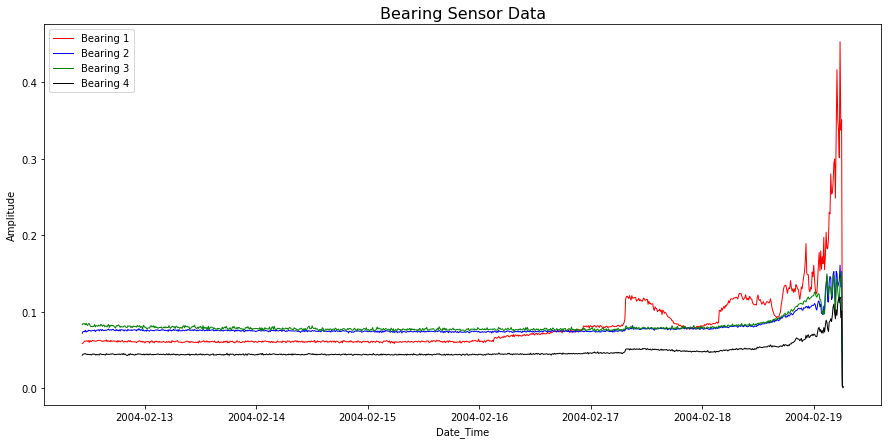

In [5]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(combined_data['Bearing1'], label='Bearing 1', color='red',linewidth=1)
ax.plot(combined_data['Bearing2'], label='Bearing 2', color='blue', linewidth=1)
ax.plot(combined_data['Bearing3'], label='Bearing 3', color='green', linewidth=1)
ax.plot(combined_data['Bearing4'], label='Bearing 4', color='black', linewidth=1)
plt.xlabel('Date_Time')
plt.ylabel("Amplitude")
plt.legend(loc='best')
ax.set_title('Bearing Sensor Data', fontsize=16)
plt.show()

### Drop last 2 rows. As the bearings failed, the machine is stopped and the vibrations becomes zero. (Near 0)

In [6]:
print(combined_data.head(5))
combined_data = combined_data[:-2]
combined_data.shape

                     Bearing1  Bearing2  Bearing3  Bearing4
2004-02-12 10:32:39  0.058333  0.071832  0.083242  0.043067
2004-02-12 10:42:39  0.058995  0.074006  0.084435  0.044541
2004-02-12 10:52:39  0.060236  0.074227  0.083926  0.044443
2004-02-12 11:02:39  0.061455  0.073844  0.084457  0.045081
2004-02-12 11:12:39  0.061361  0.075609  0.082837  0.045118


(982, 4)

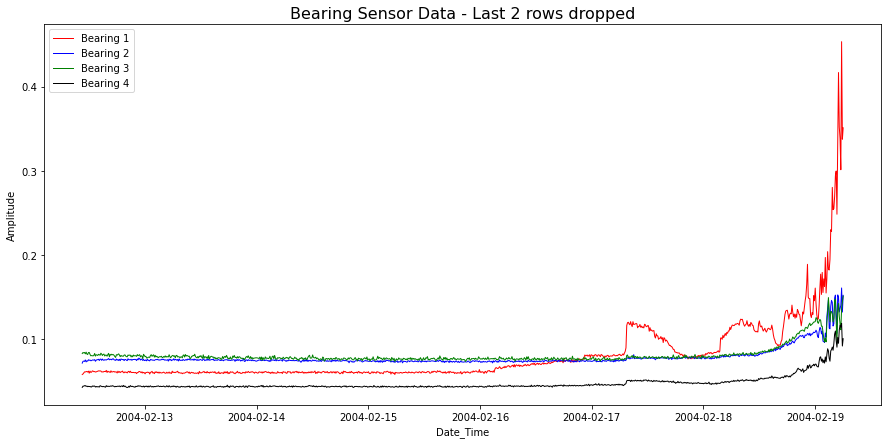

In [7]:
# Visualizing the data - last 2 rows dropped
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(combined_data['Bearing1'], label='Bearing 1', color='red',linewidth=1)
ax.plot(combined_data['Bearing2'], label='Bearing 2', color='blue', linewidth=1)
ax.plot(combined_data['Bearing3'], label='Bearing 3', color='green', linewidth=1)
ax.plot(combined_data['Bearing4'], label='Bearing 4', color='black', linewidth=1)
plt.xlabel('Date_Time')
plt.ylabel("Amplitude")
plt.legend(loc='best')
ax.set_title('Bearing Sensor Data - Last 2 rows dropped', fontsize=16)
plt.show()

## Split the Dataset into train and test set

In [8]:
train = combined_data[:'2004-02-15 12:42:39']
test = combined_data['2004-02-15 12:52:39':]

In [9]:
train.shape

(446, 4)

In [10]:
test.shape

(536, 4)

## Feature Scaling 

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## DL Model - LSTM Autoencoder

In [12]:
# import required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional,TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import SGD

In [13]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = train_scaled.reshape(train_scaled.shape[0], 1, train_scaled.shape[1])
print("Training data shape:", X_train.shape)
X_test = test_scaled.reshape(test_scaled.shape[0], 1, test_scaled.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (446, 1, 4)
Test data shape: (536, 1, 4)


In [14]:
# LSTM DL Model
model = Sequential([
    LSTM(16, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(4, activation='relu', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(4, activation='relu', return_sequences=True),
    LSTM(16, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 16)             1344      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 4)              68        
Total params: 3,236
Trainable params: 3,236
Non-trainable params: 0
______________________________________________________

In [16]:
# fit the model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05)

Train on 423 samples, validate on 23 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
423/423 [==============================] - 3s 8ms/sample - loss: 0.4468 - val_loss: 0.3184
Epoch 2/100
423/423 [==============================] - 0s 552us/sample - loss: 0.3697 - val_loss: 0.2296
Epoch 3/100
423/423 [==============================] - 0s 593us/sample - loss: 0.2554 - val_loss: 0.1460
Epoch 4/100
423/423 [==============================] - 0s 618us/sample - loss: 0.1259 - val_loss: 0.1251
Epoch 5/100
423/423 [==============================] - 0s 564us/sample - loss: 0.1061 - val_loss: 0.1159
Epoch 6/100
423/423 [==============================] - 0s 579us/sample - loss: 0.1054 - val_loss: 0.1126
Epoch 7/100
423/423 [==============================] - 0s 780us/sample - loss: 0.1046 - val_loss: 0.1104
Epoch 8/100
423/423 [==============================] - 0s 519us/sample - loss: 0.1046 - val_loss: 0.1106
Epoch 9/100
423/423 [==

Epoch 75/100
423/423 [==============================] - 0s 547us/sample - loss: 0.0699 - val_loss: 0.0753
Epoch 76/100
423/423 [==============================] - 0s 507us/sample - loss: 0.0695 - val_loss: 0.0744
Epoch 77/100
423/423 [==============================] - 0s 500us/sample - loss: 0.0696 - val_loss: 0.0758
Epoch 78/100
423/423 [==============================] - 0s 512us/sample - loss: 0.0691 - val_loss: 0.0777
Epoch 79/100
423/423 [==============================] - 0s 523us/sample - loss: 0.0699 - val_loss: 0.0730
Epoch 80/100
423/423 [==============================] - 0s 502us/sample - loss: 0.0690 - val_loss: 0.0773
Epoch 81/100
423/423 [==============================] - 0s 503us/sample - loss: 0.0685 - val_loss: 0.0778
Epoch 82/100
423/423 [==============================] - 0s 502us/sample - loss: 0.0687 - val_loss: 0.0761
Epoch 83/100
423/423 [==============================] - 0s 509us/sample - loss: 0.0683 - val_loss: 0.0742
Epoch 84/100
423/423 [========================

(0.0, 0.5)

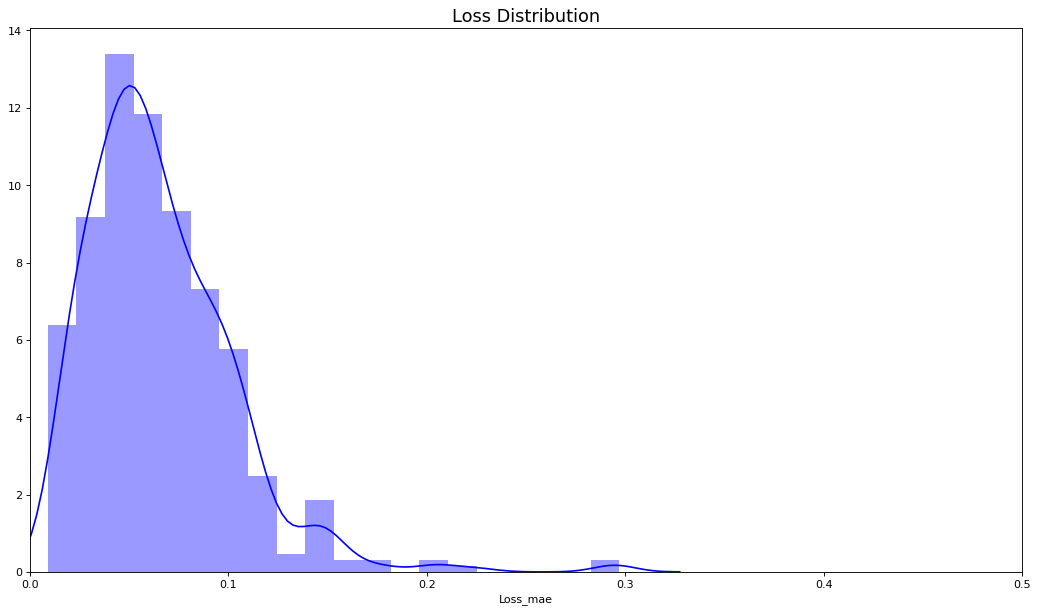

In [17]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [18]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.28
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.091693,0.28,False
2004-02-15 13:02:39,0.043733,0.28,False
2004-02-15 13:12:39,0.036626,0.28,False
2004-02-15 13:22:39,0.013002,0.28,False
2004-02-15 13:32:39,0.030656,0.28,False


In [19]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.28
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

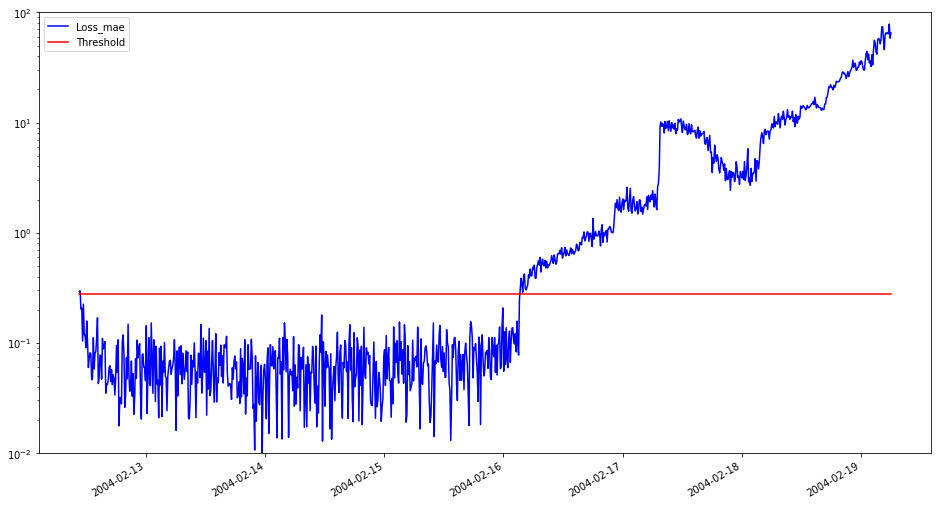

In [20]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770
* In original article NN Autoencoder, here LSTM Autoencoder is used for calculating reconstruction loss. This model reduces the false negatives.

## Inference
### For test point we have to calculate reconstruction loss (MAE)
* If MAE is less than threshold, the test point is marked as normal
* If MAE is greater than threshold, the test point is marked as Anomaly